In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from skimage import io, transform, img_as_float
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from src.loss_functions import f1_loss

sns.set(style="white")
plt.rcParams['figure.figsize'] = (12, 10)

## Understanding the dataset

In [2]:
train_labels = pd.read_csv("data/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
train_labels.shape

(31072, 2)

We have 31k training images to work with. This will later be split into a training and test set. Anticipating that this is a multi-classification/multi-label problem, let's split the Target variable, which are strings, into an array of one-hot-encoded variables.

In [4]:
one_hot = train_labels.Target.str.get_dummies(sep=' ')

In [5]:
one_hot.columns = map(int, one_hot.columns); one_hot.head()

,0,1,10,11,12,13,14,15,16,17,...,25,26,27,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Label names

In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

## Class Counts

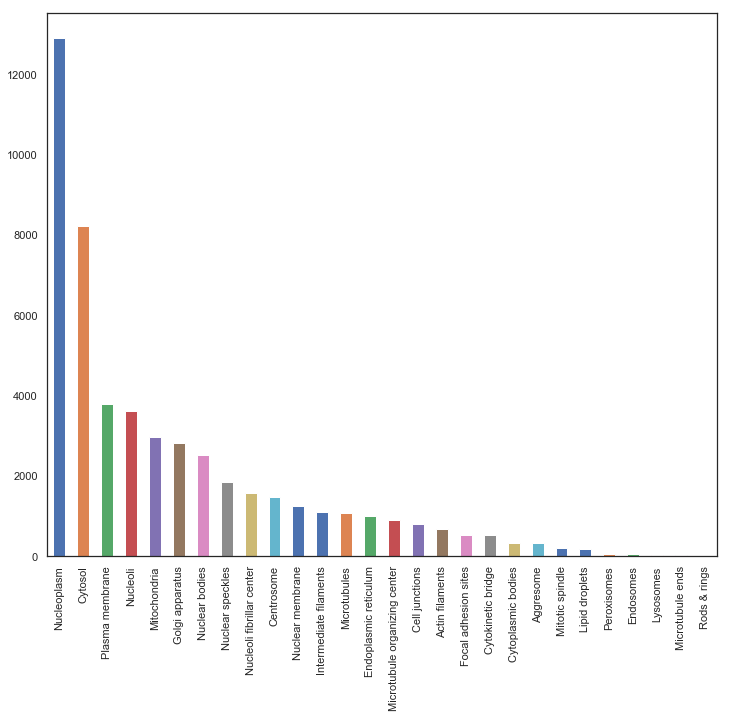

In [7]:
counts = one_hot.agg('sum')[:].rename(lambda x: label_names[x]).sort_values(ascending=False)
counts.plot('bar')

In [8]:
counts.head()

Nucleoplasm        12885
Cytosol             8228
Plasma membrane     3777
Nucleoli            3621
Mitochondria        2965
dtype: int64

In [9]:
counts.tail()

Peroxisomes         53
Endosomes           45
Lysosomes           28
Microtubule ends    21
Rods & rings        11
dtype: int64

Append one_hot labels to our train labels dataframe:

In [10]:
train_labels = train_labels.join(one_hot.sort_index(axis=1))

## Co-occurences

In [11]:
tmp1 = train_labels.iloc[:,2:]

In [12]:
co_occur = tmp1.T.dot(tmp1); co_occur.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,12885,600,1735,571,97,806,89,1092,5,0,...,279,614,58,1343,325,802,78,3631,115,7
1,600,1254,147,19,52,39,21,56,0,0,...,11,19,0,76,7,45,1,261,0,0
2,1735,147,3621,4,48,59,79,189,11,0,...,18,56,6,216,52,226,12,782,11,1
3,571,19,4,1561,23,14,24,40,4,0,...,5,20,0,35,16,51,3,272,12,0
4,97,52,48,23,1858,5,2,42,0,0,...,16,16,2,135,24,44,8,329,17,1


Now that we have a co-occurence matrix, let's plot it with a heatmap.

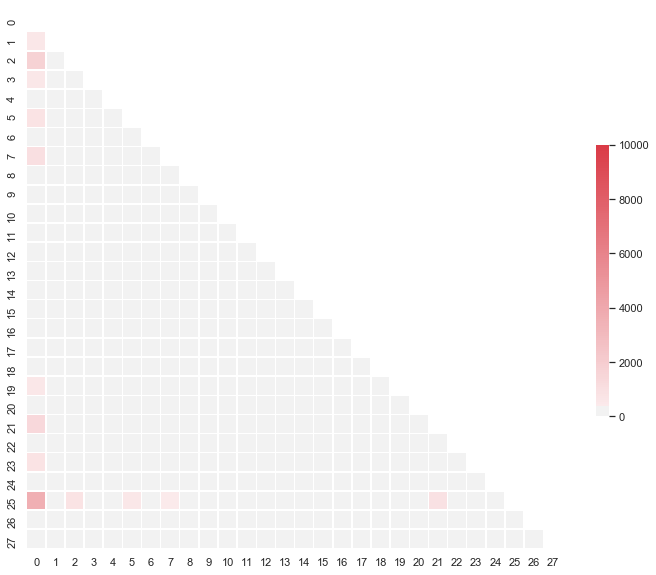

In [13]:
mask = np.zeros_like(co_occur, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(co_occur, mask=mask, cmap=cmap, vmax=10000, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The above plot doesn't tell me much because most of the variables have so few occurences that few, can be seen above the 1k number of co-occurences. Let's try plotting it on a log base-10 scale.

In [14]:
co_occur1 = co_occur.apply(np.log, args=10)

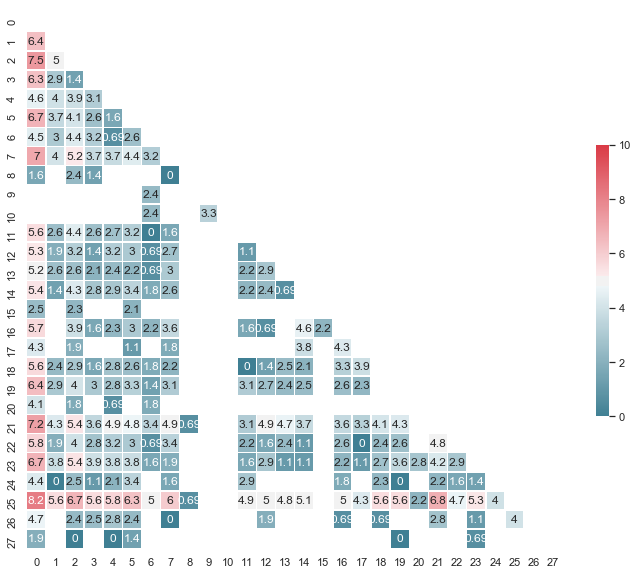

In [15]:
mask = np.zeros_like(co_occur1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(co_occur1, mask=mask, cmap=cmap, vmax=10, vmin=0, center=5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

This plot is helpful because, while still showing the high frequency of co-occurence protein 0  and 25 have with many other columns, It also shows the lack of co-occurence that protein 8,9 and 10 have with any other proteins. We may be able to use this later.

## Image reconnaissance

Let's take a look at some of the images and try to imagine what we want our net to find here

In [16]:
DIR = 'data/train_images'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

124288


In [17]:
len(train_labels) * 4

124288

Good! The number of files in the train_images directory matches 4x the number of rows in our train_labels dataframe. There is one stained image - red, blue, green, yellow for each image Id. The below code chooses a uniform random sample of 4 images and displays each color.

In [18]:
id_list = train_labels.sample(4).Id.tolist(); id_list

['2184f63e-bba7-11e8-b2ba-ac1f6b6435d0',
 '39c79f82-bb9b-11e8-b2b9-ac1f6b6435d0',
 '33de00f6-bbb0-11e8-b2ba-ac1f6b6435d0',
 '99934838-bba7-11e8-b2ba-ac1f6b6435d0']

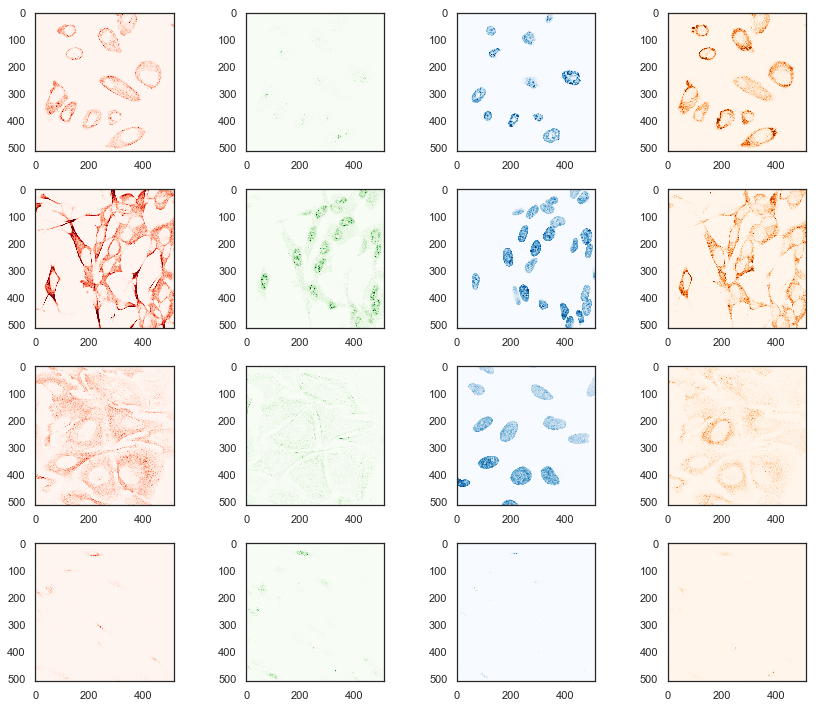

In [19]:
def plot_images_row(img_id, ax_row):
    filters = ['red', 'green', 'blue', 'yellow']
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges']
    
    for c, ax, cmap in zip(filters, ax_row, colormaps):
        filename = img_id + '_' + c + '.png'
        img=mpimg.imread(os.path.join(DIR, filename))
        imgplot = ax.imshow(img, cmap=cmap)

fig, axes = plt.subplots(nrows=4, ncols=4)

for img_id, ax_row in zip(id_list, axes):
    plot_images_row(img_id, ax_row)
 
plt.tight_layout()

We can see that each color is vaguely reminiscent of the others for the same image. Below is a larger version of one of the images shown in blue.

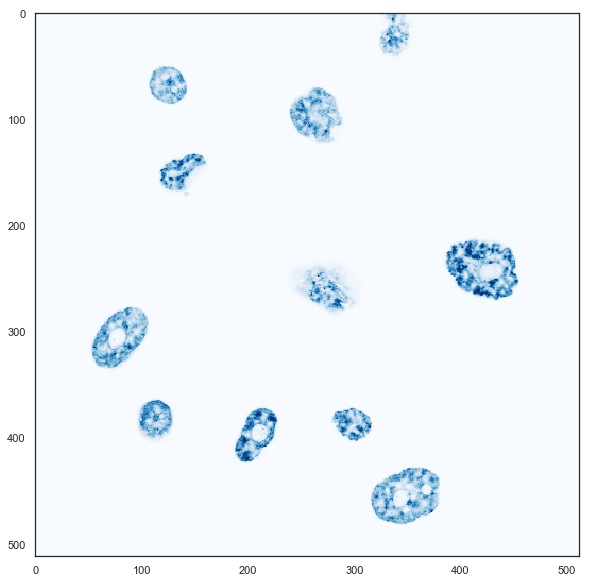

In [20]:
color = 'blue'
filename = id_list[0] + '_' + color + '.png'
img=mpimg.imread(os.path.join(DIR, filename))
plt.imshow(img, cmap="Blues")

# Baseline modeling
## Convolutional Neural Network

Conv nets take inputs as two-dimensional images and predict labels based on convolutions applied to outputs from each subsequent layer. Mathematically it is to process cross-correlations as opposed to convolutions although they are related.

For single-label classification we ask a simple question:

![car](img/streetview.jpg)

i.e. Is this a picture of a car? ∈ {yes, no}

For multi-class (per-label) classification we are interested in asking the question, "which labels are relevant to the picture?" ⊆ {car, streetlight, pedestrian, cyclist, signpost, etc..}
i.e., each instance can have multiple labels instead of a single one!

Cross-Entropy loss function is commonly used for learning a multi-class classification CNN model where overall loss on a mini-batch of n images is taken as the average additive sum of attribute-level loss with equal weight applied over all labels.

\begin{equation*}
\mathcal{L}_{ce} =
\end{equation*}

\### More about imbalanced label stuff

### Incremental Batch-Wise Class Profiling 
For hard sample mining, we first profile the minority and majority classes per label in each training mini-batch with n training samples. We profile the class distribution hj

First some supporting functions:

In [21]:
def to_one_hot(df):
    tmp = df.Target.str.get_dummies(sep=' ')
    tmp.columns = map(int, tmp.columns)
    return df.join(tmp.sort_index(axis=1))

def get_image_ids_from_dir_contents(image_dir):
    all_images = [name for name in os.listdir(image_dir) \
                  if os.path.isfile(os.path.join(image_dir, name))]
    return list(set([name.split('_')[0] for name in all_images]))

In [22]:
class TrainImageDataset(Dataset):
    """Fluorescence microscopy images of protein structures training dataset"""

    def __init__(self,
        image_dir,
        label_file,
        transform=None,
        idxs=None,
        using_pil=False
    ):
        """
        Args:
            label_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.idxs = idxs
        self.labels = to_one_hot(pd.read_csv(label_file))
        self.using_pil = using_pil
        if self.idxs is not None:
            self.labels = self.labels.iloc[self.idxs, :].\
                                                reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        img_red = img_name + '_red.png'
        img_blue = img_name + '_blue.png'
        img_green = img_name + '_green.png'
        img_yellow = img_name + '_yellow.png'

        if self.using_pil:
            pth2img = lambda x: io.imread(x)
        else:
            pth2img = lambda x: img_as_float(io.imread(x))

        img_red = pth2img(os.path.join(self.image_dir, img_red))
        img_blue = pth2img(os.path.join(self.image_dir, img_blue))
        img_green = pth2img(os.path.join(self.image_dir, img_green))
        img_yellow = pth2img(os.path.join(self.image_dir, img_yellow))
        labels = self.labels.iloc[idx, 2:].values
        labels = labels.astype('int')
        sample = {'image_id': img_name,
                  'image_red': img_red,
                  'image_blue': img_blue,
                  'image_green': img_green,
                  'image_yellow': img_yellow,
                  'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
from src.utils import get_transforms

In [24]:
train_dataset = TrainImageDataset(image_dir='data/train_images',
                                     label_file='data/train.csv',)

In [25]:
sample = train_dataset[120]

In [26]:
sample

{'image_id': '01095156-bbb7-11e8-b2ba-ac1f6b6435d0',
 'image_red': array([[0.        , 0.        , 0.        , ..., 0.00784314, 0.03137255,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02745098,
         0.05882353],
        [0.        , 0.        , 0.        , ..., 0.02745098, 0.05490196,
         0.07058824],
        ...,
        [0.        , 0.        , 0.        , ..., 0.22352941, 0.17254902,
         0.08235294],
        [0.        , 0.        , 0.        , ..., 0.09803922, 0.03529412,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.02352941, 0.01568627,
         0.01568627]]),
 'image_blue': array([[0.02352941, 0.02352941, 0.03921569, ..., 0.23529412, 0.14117647,
         0.2627451 ],
        [0.05098039, 0.02745098, 0.03921569, ..., 0.15294118, 0.2       ,
         0.14509804],
        [0.01568627, 0.03921569, 0.03529412, ..., 0.19215686, 0.16862745,
         0.17647059],
        ...,
        [0.        , 0.     

In [27]:
sample['image_red'].shape == sample['image_blue'].shape == \
sample['image_green'].shape ==  sample['image_yellow'].shape

True

In [28]:
len(sample['labels']) == 28

True

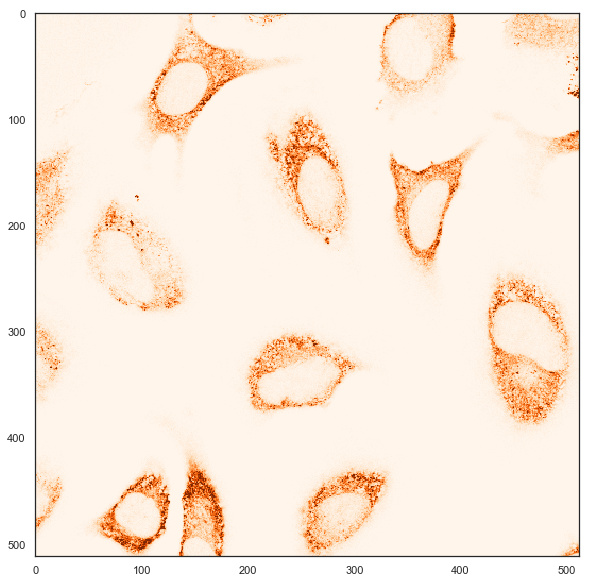

In [29]:
plt.imshow(sample['image_yellow'], cmap="Oranges")

In [686]:
transform = get_transforms(pretrained=False)
train_dataset = TrainImageDataset(image_dir='data/train_images',
                                     label_file='data/train.csv',
                                     transform=transform['TRAIN'])
kwargs = {'batch_size': 32}
trainloader = DataLoader(train_dataset, shuffle=True, **kwargs)

In [768]:
batch = next(iter(trainloader))

In [769]:
labels = batch['labels'].numpy()
images = batch['image']

In [770]:
nbs = kwargs['batch_size']
ncls = 28 # num classes

#### Class Distribution profile

$h_k^j$ number of training samples with j-th attribute value assigned to class k

In [771]:
hjk = labels.sum(axis=(0)); hjk

array([17.,  0.,  4.,  2.,  0.,  1.,  3.,  4.,  0.,  0.,  0.,  0.,  0.,
        0.,  3.,  0.,  1.,  0.,  1.,  3.,  1.,  7.,  0.,  0.,  0., 11.,
        1.,  0.], dtype=float32)

In [772]:
cls_labels = np.arange(labels.shape[1]); cls_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [773]:
sorted_cls_labels = hjk.argsort(); sorted_cls_idxs

array([27, 20, 18, 17,  8,  9, 10, 11, 16, 26, 14, 15,  1, 24,  3,  6, 13,
       12,  7,  5, 22,  2,  4, 21, 23, 19, 25,  0])

In [774]:
sorted_hjk = hjk[sorted_cls_labels]; sorted_hjk

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  2.,  3.,  3.,  3.,  4.,  4.,  7.,
       11., 17.], dtype=float32)

for the multiclass setting, we also set ρ=50%. This means that all minority classes collectively account for at most half or less samples per batch.

In [775]:
th = .5 * nbs

def get_min_class_boundary(arr):
    for idx in range(arr.size):
        if arr[:idx].sum() > th:
            return idx - 1
    return arr.size

In [776]:
bound = get_min_class_boundary(sorted_hjk)

In [777]:
sorted_hjk[:bound].sum() # should be less than 16

16.0

In [778]:
sorted_hjk = sorted_hjk[:bound]
min_cls_labels = sorted_cls_labels[:bound]; 

In [779]:
idxs = min_cls_labels.argsort() # unsort
min_cls_labels = min_cls_labels[idxs] 
hjk = sorted_hjk[idxs]
print(min_cls_labels)
print(hjk)

[ 1  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 26 27]
[0. 2. 0. 1. 3. 0. 0. 0. 0. 0. 0. 3. 0. 1. 0. 1. 3. 1. 0. 0. 0. 1. 0.]


Unfortunately those minority classes which less than two samples must be ignored so we must also filter on hjk > 1. This enables a more flexible loss function, e.g. triplet loss which requires at least two matched samples as it is impossible to construct a triple where only one or no sample images exist for that class in the batch.

In [780]:
msk = hjk > 1
hjk = hjk[msk]
min_cls_labels = min_cls_labels[msk]
print(min_cls_labels)
print(hjk)

[ 3  6 14 19]
[2. 3. 3. 3.]


Given the minortiy classes, let us find the hardness metric for sampling instances which encourage model learning to concentrate on weak recognitions or obvious mistakes. Explicitly, at the class level, we quantify sample hardness regarding a given class per label by saying for each minority class c of the attribute label j, we refer to "hard-positives" as follows: 

\begin{align}
P_{c,j}^{cls} = \{x_{i,j} | a_{i,j} = c\text{, low } p(y_{i,j} = c | x_{i,j})\}
\end{align}

\begin{align}
N_{c,j}^{cls} = \{x_{i,j} | a_{i,j} \neq c\text{, low } p(y_{i,j} = c | x_{i,j})\}
\end{align}

given some predictions:

In [781]:
bs = (nbs, ncls) # batch array size
preds = np.random.rand(*bs) # random predictions for batch 

Identify positive examples which are associated with a minority class.

$x_{i,j} | a_{i,j} = c$

In [782]:
y_min = labels[:, min_cls_labels]
msk = y_min == 1

In [783]:
P = np.argwhere(msk)

In [784]:
P

array([[ 2,  3],
       [ 4,  1],
       [ 8,  2],
       [12,  1],
       [15,  0],
       [16,  3],
       [17,  0],
       [18,  2],
       [22,  2],
       [24,  1],
       [28,  3]])

Identify negative examples which are associated with a minority class.

$x_{i,j} | a_{i,j} \neq c$

In [785]:
N = np.argwhere(~msk)

get probabilities for positive examples associated with a minority class

In [786]:
preds_min = preds[:, min_cls_labels]
probs_P = preds_min[msk]

get probabilities for negtive examples associated with a minority class

In [787]:
probs_N = preds_min[~msk]

In [788]:
select top 3 

SyntaxError: invalid syntax (<ipython-input-788-2e8fbc58d3a9>, line 1)

In [789]:
k = 3
probs_P[probs_P.argsort()][:k]

array([0.03998028, 0.05124252, 0.21173251])

Now that we know how to break down the batch into minority classes sorted on predicted probabilities, we can think about how to select hard examples. Specifically, at training time, for a minority class c of attribute label j (or a minority class instance $x_{i,j}$ ) in each training batch data, we select κ hard-positives as the bottom-κ scored on c (or bottom-κ (largest) distances to $x_{i,j}$ ), and κ hard-negatives as the top-κ scored on c (or top-κ (smallest) distance to $x_{i,j}$ ), given the current model (or feature space)

In [790]:
labels[:, min_cls_labels]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [791]:
arg_tuples = []
row_idx, col_idx = np.nonzero(labels[:, min_cls_labels] == 0)
col_idx = col_idx[col_idx.argsort()]
row_idx = row_idx[col_idx.argsort()]

In [793]:
c = 1

a = np.nonzero(labels[:, min_cls_labels][:, c] == 1)[0]; a # all instances of class c

array([ 4, 12, 24])

In [794]:
for i in combinations(a, 2): # combinations of class c
    print(i)

(4, 12)
(4, 24)
(12, 24)


In [ ]:
def select_k_hard_examples(batch_labels, selection_crit, k=3):
    """select_k_hard_examples
    
    inputs:
    batch_labels: torch.Tensor of size (nbs, ncls) where nbs is number of training examples
        in minibatch and ncls is number of classes
    sample_type: 'str', must be one of ['negative', 'positive']
    k: used for selecting top-k samples
    """
    hjk = batch_labels.sum(axis=(0)); cls_idxs = hjk > 1
    hjk = hjk[cls_idxs]
    triplets = []
    if selection_crit == 'positive':

        
    else:
    
    return triplets
    

### Minority Class Anchor Samples

There is a small number of training samples in minority classe. Because of this, it makes sense to use of them in order to effectively handle the underlying learning bias. We consider each minority class sample an “anchor” in the triplet construction.

\begin{align}
T & = \{(x_{a,j}, x_{+,j}, x_{-,j})_s\}_{s=1}^{\kappa^2}
\end{align}

At most $\kappa^2$ triplets

### Score based hard sampling (class-level)

In [103]:
nbs = (kwargs['batch_size'], 28)
preds = np.random.rand(*nbs) # random predictions for batch 

In [146]:
k = 3 # top k hard samples
mp = preds[:, minor_cls_labels]
ml = labels[:, minor_cls_labels].numpy()

hp_idxs = np.argwhere(ml == 1)
hn_idxs = np.argwhere(ml == 0)
hp = mp[l == 1]; hp.sort()
hn = mp[l == 0]; hn.sort()
print(hp[:k], hn[-k:])

[0.16052115 0.18482095 0.25724683] [0.99636657 0.99665934 0.99731215]


images xi,j of class c (ai,j = c with ai,j the groundtruth class of the attribute j)

### Feature based hard sampling

In [ ]:
DIR = 'data/test_images'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

In [ ]:
[name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))][:20]

In [ ]:
class TestImageDataset(Dataset):
    """Fluorescence microscopy images of protein structures test dataset"""

    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_ids = self.get_image_ids_from_dir_contents(image_dir)
        self.image_dir = image_dir
        self.transform = transform
    
    def get_image_ids_from_dir_contents(self, image_dir):
        all_images = [name for name in os.listdir(image_dir) \
                      if os.path.isfile(os.path.join(image_dir, name))]
        return list(set([name.split('_')[0] for name in all_images]))
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_red = img_name + '_red.png'
        img_blue = img_name + '_blue.png'
        img_green = img_name + '_green.png'
        img_yellow = img_name + '_yellow.png'
        img_red = img_as_float(io.imread(os.path.join(self.image_dir, img_red)))
        img_blue = img_as_float(io.imread(os.path.join(self.image_dir, img_blue)))
        img_green = img_as_float(io.imread(os.path.join(self.image_dir, img_green)))
        img_yellow = img_as_float(io.imread(os.path.join(self.image_dir, img_yellow)))
        sample = {'image_id': img_name,
                  'image_red': img_red,
                  'image_blue': img_blue,
                  'image_green': img_green,
                  'image_yellow': img_yellow,
                  'labels' : np.zeros(28)}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
test_dataset = TestImageDataset(image_dir='data/test_images')

In [ ]:
test_dataset[319]

In [ ]:
plt.imshow(sample['image_red'], cmap="Reds")

In [ ]:
class CombineColors(object):
    """Combines the the image in a sample to a given size."""

    def __call__(self, sample):
        img_name = sample['image_id']
        img_red = sample['image_red']
        img_blue = sample['image_blue']
        img_green = sample['image_green']
        img_yellow = sample['image_yellow']
        labels = sample['labels']
        image = np.dstack((img_red, img_blue, img_green, img_yellow))
        
        return {'image': image, 'labels': labels, 'image_id': img_name}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.DoubleTensor),
                'labels': torch.from_numpy(labels).type(torch.DoubleTensor),
                'image_id': img_name}

class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, 
    this transform will normalize each channel of the input ``torch.*Tensor`` 
    i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        transforms.Normalize(self.mean, self.std)(image)
        return {'image': image,
                'labels': labels,
                'image_id': img_name}

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.\
                                            format(self.mean, self.std)

transform = transforms.Compose(
                [CombineColors(),
                 ToTensor()])

In [ ]:
protein_image_dataset = TrainImageDataset(csv_file='data/train.csv',
                         image_dir='data/train_images', 
                         transform=transform)
n_images = len(protein_image_dataset)
arr = np.random.choice(n_images, 5000, replace=False)
train_idxs = arr[:int(5000 * .67)]
test_idxs = arr[int(5000 * .67):]
trainset = []
testset = []
print('getting training set...')
for i in tqdm(train_idxs):
    sample = protein_image_dataset[i]
    trainset.append(sample)
print('getting testing set...')
for i in tqdm(test_idxs):
    sample = protein_image_dataset[i]
    testset.append(sample)

In [ ]:
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=4)

testloader = DataLoader(testset, batch_size=4,
                        shuffle=False, num_workers=4)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5) # 4 channel in, 6 channels out, filter size 5
        self.pool = nn.MaxPool2d(2, 2) # 6 channel in, 6 channels out, filter size 2, stride 2 
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 channel in, 16 channels out, filter size 5
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 28)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(torch.relu(x))
        x = self.conv2(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 16 * 125 * 125)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # note no sigmoid layer
        return x


net = Net().double()

In [ ]:
net = torch.nn.DataParallel(net)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times
    training_loss = 0.0
    testing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        net.train()
        # get the inputs
        inputs, labels = data['image'], data['labels']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = f1_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, training_loss / 200))
            training_loss = 0.0
    for i, data in enumerate(testloader, 0):
        net.eval()
        # get the inputs
        inputs, labels = data['image'], data['labels']

        # forward + backward + optimize
        outputs = net(inputs)
        loss = f1_loss(outputs, labels)

        # print statistics
        testing_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] testing loss: %.3f' %
                  (epoch + 1, i + 1, testing_loss / 200))
            testing_loss = 0.0

print('Finished Training')

## Compute Test Predictions

Write predictions to file for submission but first lets free up some memory because I am still doing this on my laptop.

In [ ]:
# TODO: implement get test preds

## Minority Class Hard Sample Mining